# Clase 18: Métodos de paso variable

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Los métodos vistos anteriormente funcionan bastante bien en muchos casos. Sin embargo esos métodos no son óptimos cuando una función varía mucho. Por ejemplo:

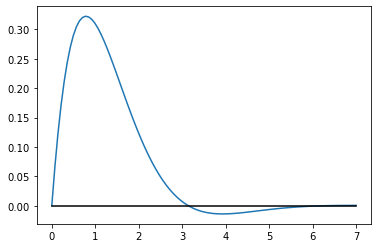

In [4]:
x = np.linspace(0,7,100)
plt.plot(x, np.exp(-x)*np.sin(x))
plt.plot(x, np.zeros(100), color = 'black')

Vemos que el intervalo entre $x = 6$ y $x = 7$ contribuye poco a la integral y además una aproximación burda puede ser buena allí. Se necesitan pocos puntos para lograr una buena aproxmación, que será cercana a cero. Sin embargo el intervalo entre $x = 0$ y $x = 3$ contribuye mucho a la integral de esta función y además la función varía rápidamente allí. Por lo tanto necesitaremos más puntos. 

## Método de cuadratura adaptativa

El método de paso adaptativo consiste en aproximar la integral como un polinomio interpolante en varios intervalos. El tamaño de cada intervalo es tal que el error cometido allí sea menor que una tolerancia $\epsilon/f$, donde $f$ es la fracción del rango de integración ocupada por el intervalo $f = (b-a)/h$. De esta forma, la suma de la aproximación en todos los subintervalos tiene un error menor que $\epsilon$.

Tenemos entonces dos tareas:

* Estimar el error cometido en una aproximación dada.
* Dividir el rango de integración para lograr el error requerido.

Para estimar el error habría que usar la fórmula de error de las aproximaciones de la clase pasada. El problema es que éstas involucran derivadas de alto orden. Recordemos la regla de simpson

$$
\int_{a}^{b} dx\,f(x) = \frac{h}{3}(f(a) + 4f(a + h) + f(b)) - \frac{h^5}{90}f^{(4)}(\xi) \equiv S_o  - \frac{h^5}{90}f^{(4)}(\xi)
$$

En general es difícil calcular la cuarta derivada, y estimarla numéricamente puede costar muchas evaluaciones de la función (además de ser inestable). Lo que podemos hacer es dividir el rango de integración a la mitad, y luego usar la regla de Simpson en cada mitad para obtener:

$$
\int_a^b dx\,f(x) = \frac{h}{6}(f(a) + 4f(a + h/2) + 2f(a + h) + 4f(a + 3h/2) + f(b)) - \frac{1}{16}\frac{h^5}{90}f^{(4)}(\bar{\xi}) \equiv S_1  - \frac{1}{16}\frac{h^5}{90}f^{(4)}(\xi)
$$

Si asumimos que $f^{(4)}(\bar{\xi}) \approx f^{(4)}(\xi)$, tenemos

$$
\frac{15}{16}\frac{h^5}{90}f^{(4)}(\xi) = S_o - S_1
$$

y entonces el error cometido al usar la aproximación S_1 es

$$
S_1 - \int_a^b dx\,f(x) = \frac{1}{15}(S_o - S_1)
$$

Para determinar los intervalos de integración la estrategia es:

1. Calcular la integral y el error en un intervalo.
2. Si el error es mayor que la tolerancia, dividir el intervalo a la mitad.
3. Repetir los pasos 1 y 2 para cada subintervalo.

In [5]:
class MaxIterations(Exception):
    pass

def adaptive(f, a, b, tol, N=100000):
    
    # Variables iniciales
    approx = 0
    i = 0
    toli = [10*tol]
    ai = [a]
    hi = [(b - a)/2]
    fai = [f(a)]
    fbi = [f(b)]
    fci = [f(a + hi[i])]
    S0i = [hi[i]*(fai[i] + 4*fci[i] + fbi[i])/3]
    Li = [1]
    
        
    
    while i >= 0:
        
        fd = f(ai[i] + hi[i]/2)
        fe = f(ai[i] + 3*hi[i]/2)
        S1 = hi[i]*(fai[i] + 4*fd + fci[i])/6
        S2 = hi[i]*(fci[i] + 4*fe + fbi[i])/6
        ai_prec = ai[i]
        hi_prec = hi[i]
        fai_prec = fai[i]
        fbi_prec = fbi[i]
        fci_prec = fci[i]
        toli_prec = toli[i]
        S0i_prec = S0i[i]
        Li_prec = Li[i]
        
        i -= 1
        if abs(S1 + S2 - S0i_prec) < toli_prec:
            approx += S1 + S2
        else:
            if Li_prec >= N:
                raise MaxIterations("Alcanzado máximo número de iteraciones.")
            
            # Intervalo derecho
            i += 1
            if i >= len(ai): # A veces hay que ampliar la lista
                ai.append(ai_prec + hi_prec)
                fai.append(fci_prec)
                fci.append(fe)
                fbi.append(fbi_prec)
                hi.append(hi_prec/2)
                toli.append(toli_prec/2)
                S0i.append(S2)
                Li.append(Li_prec + 1)
            else:
                ai[i] = ai_prec + hi_prec
                fai[i] = fci_prec
                fci[i] = fe
                fbi[i] = fbi_prec
                hi[i] = hi_prec/2
                toli[i] = toli_prec/2
                S0i[i] = S2
                Li[i] = Li_prec + 1
                
            # Intervalo izquierdo
            i += 1
            if i >= len(ai):
                ai.append(ai_prec)
                fai.append(fai_prec)
                fci.append(fd)
                fbi.append(fci_prec)
                hi.append(hi[i-1])
                toli.append(toli[i-1])
                S0i.append(S1)
                Li.append(Li[i-1])
            else:
                ai[i] = ai_prec
                fai[i] = fai_prec
                fci[i] = fd
                fbi[i] = fci_prec
                hi[i] = hi[i-1]
                toli[i] = toli[i-1]
                S0i[i] = S1
                Li[i] = Li[i-1]
                
    return approx

In [6]:
adaptive(np.cos, 0, 1, 0.00000001)

0.8414709892666887

## Cuadratura gaussiana

Este método consiste en hacer la misma integral usando polinomios, pero ahora escogemos las evaluaciones tratando de minimizar el error. Para hacerlo escribimos

$$
\int_{-1}^1 dx\,f(x) \approx \sum_{i=1}^n c_i f(x_i)
$$

Se escogen los puntos $x_i$ y los coeficientes $c_i$ tal que esta fórmula sea exacta cuando $f$ es un polinomio de grado $2n - 1$. 

**Ejemplo:** Cuando $n = 2$ podemos hacer que la integral sea exacta para todos los polinomios de orden $3$, es decir

$$
\int_{-1}^{1} dx\, f(x) = c_1 f(x_1) + c_2 f(x_2).
$$

Necesitamos escoger los números $x_1, x_2$ y $c_1, c_2$ tal que esto se cumpla. Pero podemos enfocarnos en que sea verdad para polinomios del tipo $x^n$ ya que

$$
\int_{-1}^1 dx\, f(x) = a_3 \int_{-1}^1 dx\,x^3 + a_2 \int_{-1}^1 dx\,x^2 + a_1 \int_{-1}^1 dx\,x + a_o \int_{-1}^1 dx 
$$

Empezamos por $f(x) = 1$:

$$
c_1 + c_2 = \int_{-1}^1 dx\,1 = 2
$$

Ahora con $f(x) = x$:

$$
c_1x_1 + c_2 x_2 = \int_{-1}^1 dx\,x = 0
$$

Ahora con $f(x) = x^2$:

$$
c_1 x_1^2 + c_2 x_2^2 = \int_{-1}^1 dx\,x^2 = \frac{2}{3}
$$

Finalmente con $f(x) = x^3$:

$$
c_1 x_1^3 + c_2 x_2^3 = \int_{-1}^1 dx\,x^3 = 0
$$

Son cuatro ecuaciones para cuatro números cuya solución es

$$
c_1 = 1\,,\,\,c_2 = 1\,,\,\,x_1 = -\frac{\sqrt{3}}{3}\,,\,\,x_2 = \frac{\sqrt{3}}{3}
$$

Hay un método más sistemático que involucra polinomios ortogonales. Recordemos que los polinomios de Legendre satisfacen:

$$
\int_{-1}^1 dx\,P_n(x) P_m(x) \propto \delta_{nm}
$$

Además toda función en el intervalo $(-1, 1)$ se puede escribir como combinación lineal de polinomios de Legendre

$$
f(x) = \sum_{n = 0}^\infty c_n P_n(x)
$$

En particular, un polinomio de orden $m$ se puede escribir como

$$
P(x) = \sum_{n=0}^m c_n P_n(x)
$$

tal que, si $m < n$, tenemos

$$
\int_{-1}^1 dx\,P_n(x) P(x) = 0 
$$

Resulta que los ceros del polinomio de Legendre de orden $n$ (o en general polinomios ortogonales) nos dan los coeficientes para la cuadratura de Gauss de orden $n$.

Para verlo, supongamos que integramos un polinomio de orden $<n$, entonces podemos descomponerlo en polinomios de Lagrange alrededor de los ceros del polinomio de Legendre $x_i$

$$
P(x) = \sum_{i=1}^n P(x_i) L_i(x) = \sum_{i=1}^n \prod_{j = 1,j\neq i}^n \frac{x - x_j}{x_i-x_j} P(x_i)
$$

La igualdad es exacta para polinomios de grado $<n$ (el término de error es proporcional a $f^{(n)}$ que es cero para estos polinominos) y cualquier conjunto de puntos $x_i$. Al integrar obtenemos

$$
\int_{-1}^1 dx\,P(x) = \sum_{i=1}^n P(x_i) \int_{-1}^1dx\,\prod_{j = 1,j\neq i}^n \frac{x - x_j}{x_i-x_j}
$$

Entonces se cumple la igualdad con 

$$
c_i = \int_{-1}^1dx\,\prod_{j = 1,j\neq i}^n \frac{x - x_j}{x_i-x_j}
$$

Ahora para polinomios de grado $\geq n$ pero $< 2n$ tenemos que podemos siempre escribirlos de la forma

$$
P(x) = Q(x) P_n(x) + R(x)
$$

donde $Q(x)$ es el polinomio cociente, de orden $<n$, y $R(x)$ es el polinomio residuo de orden $<n$. Por la propiedad de los polinomios de Legendre

$$
\int_{-1}^1dx\,P(x) = \int_{-1}^1dx\,Q(x) P_n(x) + \int_{-1}^1dx\,R(x) = \int_{-1}^1dx\,R(x)
$$

Como el orden de $R$ es menor que $n$, se cumple el argumento de antes y tenemos

$$
\int_{-1}^1dx\,P(x) = \sum_{i=1}^n R(x_i) \int_{-1}^1dx\,\prod_{j = 1,j\neq i}^n \frac{x - x_j}{x_i-x_j}
$$

Además, si tomamos que los $x_i$ sean los ceros del polinomio de Legendre

$$
P(x_i) = R(x_i)
$$

y entonces 

$$
\int_{-1}^1dx\,P(x) = \sum_{i=1}^n P(x_i) \int_{-1}^1dx\,\prod_{j = 1,j\neq i}^n \frac{x - x_j}{x_i-x_j}
$$

In [7]:
def gauss_quad_5(f, a, b):
    
    def x(t):
        return ((b - a)*t + a + b)/2
    
    c = [0.2369268850, 0.4786286705, 0.5688888889, 0.4786286705, 0.2369268850]
    r = [0.9061798459, 0.5384693101, 0.0000000000, -0.5384693101, -0.9061798459]
    
    return ((b-a)/2)*sum(c[i]*f(x(r[i])) for i in range(5))

In [8]:
gauss_quad_5(np.cos, 0, 2)

0.9092974272317184

## Scipy

In [9]:
from scipy import integrate
x2 = lambda x: x**2
integrate.quad(x2, 0, 4)

(21.333333333333336, 2.368475785867001e-13)

In [10]:
print(4**3 / 3.)

21.333333333333332


También tiene argumentos epsrel y epsabs que determinan el error relativo y absoluto requerido. Si se quiere que únicamente alcance el error relativo sin dar importancia al error absoluto, es necesario poner epsabs=0.

In [11]:
from scipy import integrate
f = lambda x: np.cos(10*x)/np.sqrt(x**2 + 16)
integrate.quad(f, 0, 2, epsrel=1e-12, epsabs=0)

(0.0203266092465018, 3.448616029633677e-15)

El algoritmo que usa por defecto es una especie de cuadratura adaptativa, donde en cada intervalo aplica una método similar a la cuadratura gaussiana de orden 21.

## Tareas

### Tarea 9.6

Escriba un código que implemente una cuadratura gaussiana compuesta. Es decir, divide el rango de integración en $n$ subintervalos y aplica una cuadratura gaussiana en cada uno.

### Tarea 9.7

Suponga que la medición de un cierto proceso físico da como resultado la siguiente expresión

$$
p(x) = \sin x + n(x)
$$

donde $n$ es el error experimental que podemos describir como un número aleatorio, para cada valor de $x$, tomado de una distribución gaussiana con media $0$ y desviación estándar $10^{-5}$. Queremos calcular la integral

$$
\int_0^1 dx\,p(x)\,.
$$

Use la cuadratura adaptativa para calcular esta integral. El verdadero valor de esta integral es $1-\cos(1)$. Grafique el error cometido en función de la tolerancia. ¿Se puede lograr una precisión de $10^{-7}$? ¿Qué podemos decir sobre la estabilidad de la cuadratura adaptativa?

### Tarea 9.8

Calcule la integral del seno entre $0$ y $1$. Para ello use el método compuesto de Simpson y la cuadratura adaptativa implementada en clase. Hágalo para varias precisiones y grafique el tiempo que tardan ambos métodos en función de la precisión. (Para la precisión del método de Simpson es necesario usar la fórmula de error para calcular el número $n$ de intervalos).

### Tarea 9.9

Calcule la siguiente integral

$$
\int_{0.1}^1 dx\,\frac{\ln(x)}{\sqrt{\cos^2(x) + \tanh(x)}}
$$

Hágalo usando la cuadratura adaptativa y el integrador de scipy. Grafique los tiempos que tardan ambos en función de la precisión pedida.

### Tarea 9.10

Ejercicio 4.6.10 del libro de análisis numérico de Burden.

El estudio de la difracción de la luz en una apertura rectangular involucra las integrales de Fresnel

$$
c(t) = \int_0^t dw\,\cos\frac{\pi}{2}w^2\,,\quad s(t) = \int_0^t dw\,\sin\frac{\pi}{2}w^2\,.
$$

Construya una tabla de integrales de Fresnel con una precisión de $10^{-4}$ para los valores $t = 0.1, 0.2, ..., 0.9, 1.0$.